In [1]:
%matplotlib inline


# Local Binary Pattern for texture classification


In this example, we will see how to classify textures based on LBP (Local
Binary Pattern). LBP looks at points surrounding a central point and tests
whether the surrounding points are greater than or less than the central point
(i.e. gives a binary result).

Before trying out LBP on an image, it helps to look at a schematic of LBPs.
The below code is just used to plot the schematic.


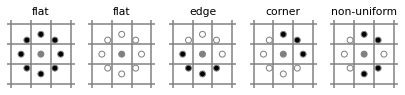

In [2]:
import numpy as np
import matplotlib.pyplot as plt


METHOD = 'uniform'
plt.rcParams['font.size'] = 9


def plot_circle(ax, center, radius, color):
    circle = plt.Circle(center, radius, facecolor=color, edgecolor='0.5')
    ax.add_patch(circle)


def plot_lbp_model(ax, binary_values):
    """Draw the schematic for a local binary pattern."""
    # Geometry spec
    theta = np.deg2rad(45)
    R = 1
    r = 0.15
    w = 1.5
    gray = '0.5'

    # Draw the central pixel.
    plot_circle(ax, (0, 0), radius=r, color=gray)
    # Draw the surrounding pixels.
    for i, facecolor in enumerate(binary_values):
        x = R * np.cos(i * theta)
        y = R * np.sin(i * theta)
        plot_circle(ax, (x, y), radius=r, color=str(facecolor))

    # Draw the pixel grid.
    for x in np.linspace(-w, w, 4):
        ax.axvline(x, color=gray)
        ax.axhline(x, color=gray)

    # Tweak the layout.
    ax.axis('image')
    ax.axis('off')
    size = w + 0.2
    ax.set_xlim(-size, size)
    ax.set_ylim(-size, size)


fig, axes = plt.subplots(ncols=5, figsize=(7, 2))

titles = ['flat', 'flat', 'edge', 'corner', 'non-uniform']

binary_patterns = [np.zeros(8),
                   np.ones(8),
                   np.hstack([np.ones(4), np.zeros(4)]),
                   np.hstack([np.zeros(3), np.ones(5)]),
                   [1, 0, 0, 1, 1, 1, 0, 0]]

for ax, values, name in zip(axes, binary_patterns, titles):
    plot_lbp_model(ax, values)
    ax.set_title(name)

The figure above shows example results with black (or white) representing
pixels that are less (or more) intense than the central pixel. When
surrounding pixels are all black or all white, then that image region is
flat (i.e. featureless). Groups of continuous black or white pixels are
considered "uniform" patterns that can be interpreted as corners or edges.
If pixels switch back-and-forth between black and white pixels, the pattern
is considered "non-uniform".

When using LBP to detect texture, you measure a collection of LBPs over an
image patch and look at the distribution of these LBPs. Lets apply LBP to a
brick texture.



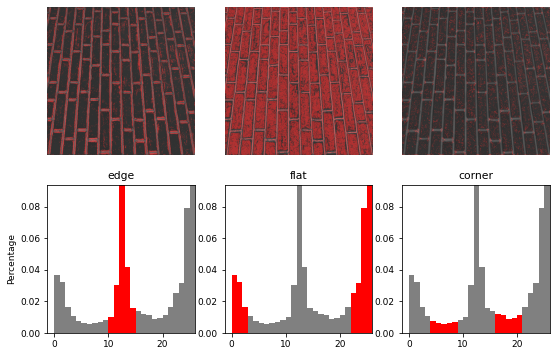

In [3]:
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb

# settings for LBP
radius = 3
n_points = 8 * radius


def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')


image = data.brick()
lbp = local_binary_pattern(image, n_points, radius, METHOD)


def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')


# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')

The above plot highlights flat, edge-like, and corner-like regions of the
image.

The histogram of the LBP result is a good measure to classify textures.
Here, we test the histogram distributions against each other using the
Kullback-Leibler-Divergence.



Rotated images matched against references using LBP:
original: brick, rotated: 30deg, match result:  brick
original: brick, rotated: 70deg, match result:  brick
original: grass, rotated: 145deg, match result:  grass


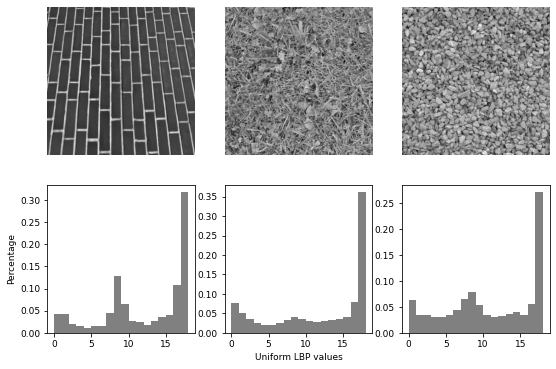

In [4]:
# settings for LBP
radius = 2
n_points = 8 * radius


def kullback_leibler_divergence(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    filt = np.logical_and(p != 0, q != 0)
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))


def match(refs, img):
    best_score = 10
    best_name = None
    lbp = local_binary_pattern(img, n_points, radius, METHOD)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    for name, ref in refs.items():
        ref_hist, _ = np.histogram(ref, density=True, bins=n_bins,
                                   range=(0, n_bins))
        score = kullback_leibler_divergence(hist, ref_hist)
        if score < best_score:
            best_score = score
            best_name = name
    return best_name


brick = data.brick()
grass = data.grass()
gravel = data.gravel()

refs = {
    'brick': local_binary_pattern(brick, n_points, radius, METHOD),
    'grass': local_binary_pattern(grass, n_points, radius, METHOD),
    'gravel': local_binary_pattern(gravel, n_points, radius, METHOD)
}

# classify rotated textures
print('Rotated images matched against references using LBP:')
print('original: brick, rotated: 30deg, match result: ',
      match(refs, rotate(brick, angle=30, resize=False)))
print('original: brick, rotated: 70deg, match result: ',
      match(refs, rotate(brick, angle=70, resize=False)))
print('original: grass, rotated: 145deg, match result: ',
      match(refs, rotate(grass, angle=145, resize=False)))

# plot histograms of LBP of textures
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3,
                                                       figsize=(9, 6))
plt.gray()

ax1.imshow(brick)
ax1.axis('off')
hist(ax4, refs['brick'])
ax4.set_ylabel('Percentage')

ax2.imshow(grass)
ax2.axis('off')
hist(ax5, refs['grass'])
ax5.set_xlabel('Uniform LBP values')

ax3.imshow(gravel)
ax3.axis('off')
hist(ax6, refs['gravel'])

plt.show()